# IBM Developer Skills Network

# Data Augmentation

In this lab, we train a Convolutional Neural Network with Regular data and Augmented data. The purpose of this lab is to show that the Augmented data improves generalization performance.

Think of a scenario where a drone has to take a picture of an object. The drone is moving and the object can also possibly be moving. When an image is taken we arent always going to get perfect images. The subject may not be perfectly centered in the image or the subject may be rotated in the image. In this case, a model trained on perfectly centered or rotated images won't perform well. This is why we train a model on rotated data so it can perform well on imperfect images.

In this assignment, we will use a dataset of digit images. We will have two models one trained on non rotated digits and one trained on rotated images and then we will test the models on a rotated testing dataset which will be more realistic and robust in terms of our scenario above.

In [1]:
# Pretrain model link
# 'https://github.com/sonpn82/Introduction-to-computer-vision-and-image-processing/blob/master/normal.pt?raw=true'

In [2]:
# Pretrain rotated model link
# 'https://github.com/sonpn82/Introduction-to-computer-vision-and-image-processing/blob/master/rotated_data.pt?raw=true'

In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms  # to transform data
import torchvision.datasets as dsets

import matplotlib.pylab as plt
import numpy as np
import os  # to access file system

In [4]:
# Plot cost and accuracy vs epoch
def plot_cost_accuracy(checkpoint):

# Plot the cost and accuracy

    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(checkpoint['cost'], color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('Cost', color=color)
    ax1.tick_params(axis='y', color=color)
    
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color) 
    ax2.set_xlabel('epoch', color=color)
    ax2.plot( checkpoint['accuracy'], color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()

In [5]:
# function to plot out data samples as images
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

In [6]:
# Plot the 5 mis_classified samples
def plot_mis_classified(model, dataset):
    count=0
    for x, y in torch.utils.data.DataLoader(dataset=dataset, batch_size=1):
        z = model(x)
        _, yhat = torch.max(z, 1)
        if yhat != y:
            show_data((x, y))
            plt.show()
            count += 1
        if count >= 5:
            break 

# Load Data

We create a transform object compose one will resize the image and convert it to a tensor, the second will also rotate the image Randomly rotate the image.

In [7]:
IMAGE_SIZE = 16

# Creating a group of transformations to created a rotated dataset
# Resizes the images, randomly rotates it, and then converts it to a tensor
compose_rotate = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),transforms.RandomAffine(45), transforms.ToTensor()])

# Creating a group of transformations to created a non rotated dataset
# Resizes the images then converts it to a tensor
compose = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

In [8]:
# The transform parameters is set to the corresponding compose
train_dataset_rotate = dsets.MNIST(root='./data', train=True, download=True, transform=compose_rotate)
train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=compose)

In [9]:
# Load the testing dataset
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=compose_rotate)

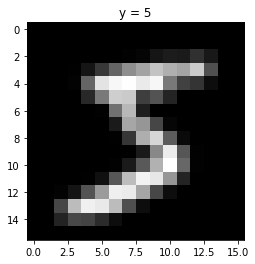

In [10]:
# Plot the 1st sample
show_data(train_dataset[0])

In [11]:
# Label for the 1st data element
train_dataset[0][1]

5

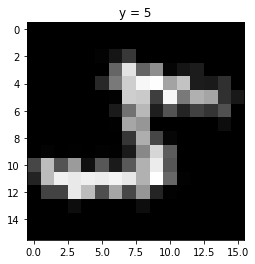

In [12]:
# Plot the 1st sample of the rotated dataset
show_data(train_dataset_rotate[0])

# Build a Convolutional Neural Network Class

Build a Convolutional Network class with two Convolutional layers and one fully connected layer. Pre-determine the size of the final output matrix. The parameters in the constructor are the number of output channels for the first and second layers.

In [13]:
class CNN(nn.Module):
    
    # Contructor
    def __init__(self, out_1=16, out_2=32):
        super(CNN, self).__init__()
        
        # The reason we start with 1 channel is because we have a single black and white image
        # Channel Width after this layer is 16
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        # Channel Wifth after this layer is 8
        self.maxpool1=nn.MaxPool2d(kernel_size=2)
        
        # Channel Width after this layer is 8
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        # Channel Width after this layer is 4
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        # In total we have out_2 (32) channels which are each 4 * 4 in size based on the width calculation above. Channels are squares.
        # The output is a value for each class
        self.fc1 = nn.Linear(out_2 * 4 * 4, 10)
    
    # Prediction
    def forward(self, x):
        # Puts the X value through each cnn, relu, and pooling layer and it is flattened for input into the fully connected layer
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

    # Outputs result of each stage of the CNN, relu, and pooling layers
    def activations(self, x):
        # Outputs activation this is not necessary
        z1 = self.cnn1(x)
        a1 = torch.relu(z1)
        out = self.maxpool1(a1)
        
        z2 = self.cnn2(out)
        a2 = torch.relu(z2)
        out1 = self.maxpool2(a2)
        out = out.view(out.size(0),-1)
        return z1, a1, z2, a2, out1,out

# Regular Data

In [14]:
# Create the model object to be trained on regular data using CNN
model = CNN(out_1=16, out_2=32)

In [15]:
# Define the criterion
criterion = nn.CrossEntropyLoss()

# Learning rate
learning_rate = 0.1

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)

# Data loader for rotated validation data
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)


Below code is to train and save the model. We will just load the result this time.

In [ ]:
# Train the model
import os

# Location of saved model
file_normal = os.path.join(os.getcwd(), 'normal.pt')

# All the data we are saving
checkpoint={
            # Saving the number of epochs the models was trained for
            'epoch': None,
            # Saving the models parameters which will allow us to recreate the trained model
            'model_state_dict': None,
            # Saving the optimizers parameters
            'optimizer_state_dict': None,
            # Saving the loss on the training dataset for the last batch of the last epoch
            'loss': None,
            # Saving the cost on the training dataset for each epoch
            'cost': [],
            # Saving the accuracy for the testing dataset for each epoch
            'accuracy': []}

# number of epoch
n_epochs = 5

# Size of the testing dataset
N_test = len(validation_dataset)

# Training for the number of epochs we want
for epoch in range(n_epochs):
    cost = 0
    for x, y in train_loader:
        # Resets the calculated gradient value, this must be done each time as it accumulates if we do not reset
        optimizer.zero_grad()
        # Makes a prediction on the image
        z = model(x)
        # Calculate the loss between the prediction and actual class
        loss = criterion(z, y)
        # Calculates the gradient value with respect to each weight and bias
        loss.backward()
        # Updates the weight and bias according to calculated gradient value
        optimizer.step()
      
        # Saves the number of epochs we trained for  
        checkpoint['epochs'] = n_epochs
        # Saves the models parameters
        checkpoint['model_state_dict'] = model.state_dict()
        # Saves the optimizers paramters
        checkpoint['optimizer_state_dict'] = optimizer.state_dict()
        # Saves the loss for the last batch so ultimately this will be the loss for the last batch of the last epoch
        checkpoint['loss'] = loss
        # Accumulates the loss
        cost += loss.item()
        
     
    # Counter for the correct number of predictions        
    correct = 0
        
    # For each batch in the validation dataset
    for x_test, y_test in validation_loader:
        # Make a prediction
        z = model(x_test)
        # Get the class that has the maximum value
        _, yhat = torch.max(z.data, 1)
        # Counts the number of correct predictions made
        correct += (yhat == y_test).sum().item()
 
    accuracy = correct / N_test
    print(accuracy)
    # Appends the cost of the epoch to a list
    checkpoint['cost'].append(cost) 
    # Appends the accuracy of the epoch to a list
    checkpoint['accuracy'].append(accuracy)
    # Saves the data in checkpoint to the file location
    torch.save(checkpoint, file_normal) 

# Analyze the Results

In [16]:
# Load the saved model
checkpoint_normal = torch.load(os.path.join(os.getcwd(), 'normal.pt'))

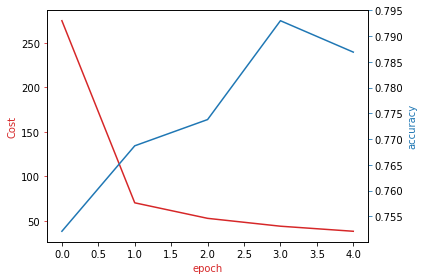

In [17]:
# Plot accuracy and cost
plot_cost_accuracy(checkpoint_normal)

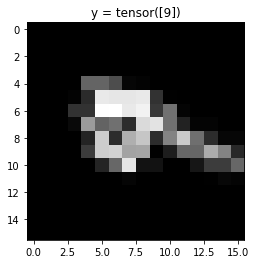

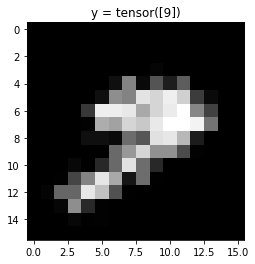

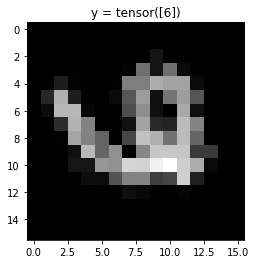

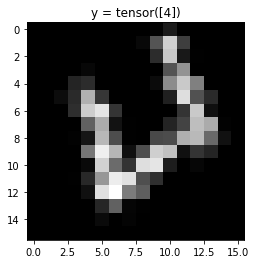

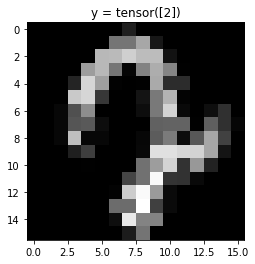

In [18]:
# Misclassified samples
model.load_state_dict(checkpoint_normal['model_state_dict'])

# set the model to evaluation mode
model.eval()

# plot
plot_mis_classified(model, validation_dataset)

# Rotated training Data

In [20]:
# Create the model
model_r = CNN(out_1=16, out_2=32)

# criterion
criterion = nn.CrossEntropyLoss()

# learning rate
learning_rate = 0.1

# optimizer
optimizer = torch.optim.SGD(model_r.parameters(), lr = learning_rate)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset_rotate, batch_size=100)

# validation loader
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

The below cell is for training the model. We will not run it this time.

In [ ]:
# Train the model
# Location to save the data
file_rotated = os.path.join(os.getcwd(), 'rotated_data.pt')

# All the data we are saving
checkpoint={
            # Saving the number of epochs the models was trained for
            'epoch': None,
            # Saving the models parameters which will allow us to recreate the trained model
            'model_state_dict': None,
            # Saving the optimizers parameters
            'optimizer_state_dict': None,
            # Saving the loss on the training dataset for the last batch of the last epoch
            'loss': None,
            # Saving the cost on the training dataset for each epoch
            'cost': [],
            # Saving the accuracy for the testing dataset for each epoch
            'accuracy': []}
            
# Number of epochs to train model
n_epochs = 5

# size of the testing dataset
N_test = len(validation_dataset)

# Training for the number of epochs we want
for epoch in range(n_epochs):
    cost = 0
    # For each batch in the training dataset
    for x, y in train_loader:
        # Resets the calculated gradient value, this must be done each time as it accumulates if we do not reset
        optimizer.zero_grad()
        # Makes a prediction on the image
        z = model_r(x)
        # Calculate the loss between the prediction and actual class
        loss = criterion(z, y)
        # Calculates the gradient value with respect to each weight and bias
        loss.backward()
        # Updates the weight and bias according to calculated gradient value
        optimizer.step()
      
        # Saves the number of epochs we trained for  
        checkpoint['epochs'] = n_epochs
        # Saves the models parameters
        checkpoint['model_state_dict'] = model.state_dict()
        # Saves the optimizers paramters
        checkpoint['optimizer_state_dict'] = optimizer.state_dict()
        # Saves the loss for the last batch so ultimately this will be the loss for the last batch of the last epoch
        checkpoint['loss'] = loss
        # Accumulates the loss
        cost+=loss.item()
        
     
    # Counter for the correct number of predictions        
    correct = 0
        
    # For each batch in the validation dataset
    for x_test, y_test in validation_loader:
        # Make a prediction
        z = model_r(x_test)
        # Get the class that has the maximum value
        _, yhat = torch.max(z.data, 1)
        # Counts the number of correct predictions made
        correct += (yhat == y_test).sum().item()
 
    accuracy = correct / N_test
    print(accuracy)
    # Appends the cost of the epoch to a list
    checkpoint['cost'].append(cost) 
    # Appends the accuracy of the epoch to a list
    checkpoint['accuracy'].append(accuracy)
    # Saves the data in checkpoint to the file location
    torch.save(checkpoint, file_rotated) 

## Analyze the result

In [21]:
checkcpoint_rotated = torch.load(os.path.join(os.getcwd(), 'rotated_data.pt'))

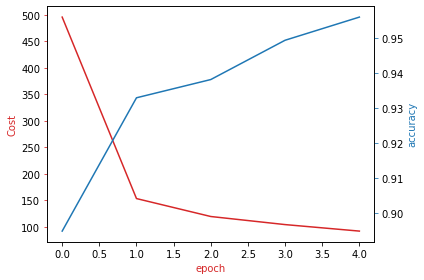

In [22]:
# Plot the accuracy
plot_cost_accuracy(checkcpoint_rotated)

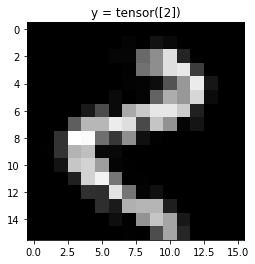

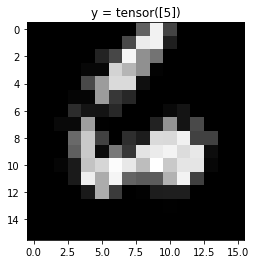

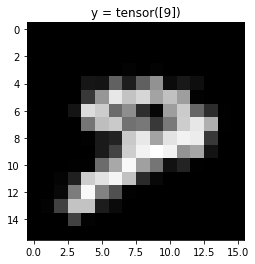

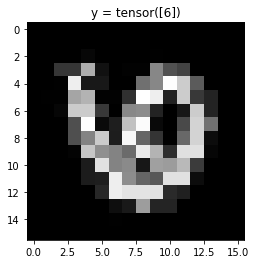

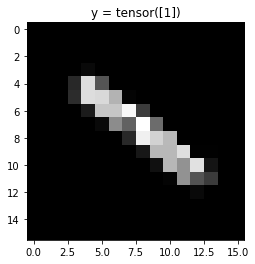

In [23]:
# Five misclassified samples
model_r.load_state_dict(checkcpoint_rotated['model_state_dict'])

# Setting the model to evaluation mode
model.eval()

# Plot
plot_mis_classified(model_r, validation_dataset)

# Summary

As you can see in the two Cost and Accuracy vs Epoch Graph the model trained on rotated data performs much better on the rotated validation data, 79% vs 95%+. By creating and training on rotated data allows the model to learn from unique data and have increased exposure to real life situations because data is not always perfect or rotated correctly.